# 2A.ml - Imbalanced dataset

Un jeu de données *imbalanced* signifie qu'une classe est sous représentée dans un problème de classification. Lire [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset](http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Génération de données

On génère un problème de classification binaire avec une classe sous représentée.

In [3]:
import numpy.random
import pandas

def generate_data(nb, ratio, noise):
    mat = numpy.random.random((nb,2))
    noise = numpy.random.random((mat.shape[0],1)) * noise
    data = pandas.DataFrame(mat, columns=["X1", "X2"])
    data["decision"] = data.X1 + data.X2 + noise.ravel()
    vec = list(sorted(data["decision"]))
    l = len(vec)- 1 - int(len(vec) * ratio)
    seuil = vec[l]
    data["cl"] = data["decision"].apply(lambda r: 1 if r > seuil else 0)
    from sklearn.utils import shuffle
    data = shuffle(data)
    return data

data = generate_data(1000, 0.08, 0.1)
data.describe()

,X1,X2,decision,cl
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.501011,0.497330,1.047568,0.080000
std,0.281113,0.295740,0.410862,0.271429
min,0.001387,0.001413,0.032132,0.000000
25%,0.274936,0.238735,0.776950,0.000000
50%,0.505160,0.491212,1.025373,0.000000
75%,0.729076,0.752400,1.340745,0.000000
max,0.999988,0.999728,2.048328,1.000000


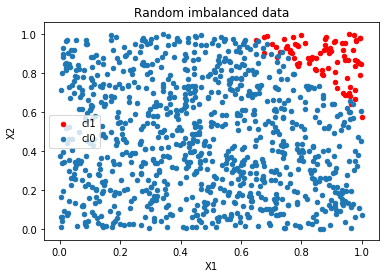

In [4]:
ax = data[data.cl==1].plot(x="X1", y="X2", kind="scatter", label="cl1", color="r")
data[data.cl==0].plot(x="X1", y="X2", kind="scatter", label="cl0", ax=ax)
ax.set_title("Random imbalanced data");

In [5]:
from sklearn.model_selection import train_test_split
while True:
    X_train, X_test, y_train, y_test = train_test_split(data[["X1", "X2"]], data["cl"])
    if sum(y_test) > 0:
        break

Le découpage apprentissage est délicat car il n'y pas beaucoup d'exemples pour la classe sous-représentée.

In [6]:
y_test.sum()

22

## Apprendre et tester un modèle

Pour ce type de problème, un modèle qui retourne la classe majoritaire quelque soit le cas est déjà un bon modèle puisqu'il retourne la bonne réponse dans la majorité des cas.

In [7]:
from sklearn.metrics import confusion_matrix

def confusion(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predt = model.predict(X_train)
    c_train = confusion_matrix(y_train, predt)
    pred = model.predict(X_test)
    c_test = confusion_matrix(y_test, pred)
    return pandas.DataFrame(numpy.hstack([c_train, c_test]), index=["y=0", "y=1"],
                            columns="train:y=0 train:y=1 test:y=0 test:y=1".split())

from sklearn.linear_model import LogisticRegression
confusion(LogisticRegression(solver='lbfgs'),
          X_train, X_test, y_train, y_test)

,train:y=0,train:y=1,test:y=0,test:y=1
y=0,692,0,228,0
y=1,34,24,12,10


Quelques exemples pour tester, quelques exemples pour apprendre. C'est peu.

In [8]:
from sklearn.tree import DecisionTreeClassifier
confusion(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)

,train:y=0,train:y=1,test:y=0,test:y=1
y=0,692,0,227,1
y=1,0,58,2,20


In [9]:
from sklearn.ensemble import RandomForestClassifier
confusion(RandomForestClassifier(n_estimators=10),
          X_train, X_test, y_train, y_test)

,train:y=0,train:y=1,test:y=0,test:y=1
y=0,692,0,227,1
y=1,1,57,2,20


L'algorithme de la régression logistique converge plus difficile que celui des arbres de décision. Voyons comment cela évolue entre de la norme *L1* ou *L2* et de la proportion de la classe mal balancée.

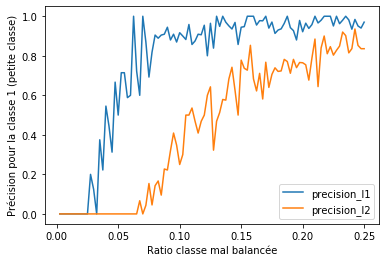

In [10]:
ratio = list(_/400.0 for _ in range(1, 101))
rows = []
for r in ratio:
    data = generate_data(1000, r, noise=0.0)
    while True:
        X_train, X_test, y_train, y_test = train_test_split(data[["X1", "X2"]], data["cl"])
        if sum(y_test) > 0 and sum(y_train) > 0:
            break
    c = confusion(LogisticRegression(penalty='l1', solver='liblinear'),
                  X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1", "test:y=0"], c.loc["y=1", "test:y=1"]
    row = dict(ratio=r, precision_l1=c1 / (c0 + c1) )
    c = confusion(LogisticRegression(penalty='l2', solver="liblinear"),
                  X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1", "test:y=0"], c.loc["y=1", "test:y=1"]
    row["precision_l2"] = c1 / (c0 + c1)
    rows.append(row)
df = pandas.DataFrame(rows)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
df.plot(x="ratio", y=[_ for _ in df.columns if _ !="ratio"], ax=ax)
ax.set_xlabel("Ratio classe mal balancée")
ax.set_ylabel("Précision pour la classe 1 (petite classe)");

La norme **l1** est plus sensible aux petites classes. La métrique [balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) calcule la performance du modèle en donnant le même poids quelque soit la taille de la classe, il fait la moyenne de l'*accuracy* par classe.

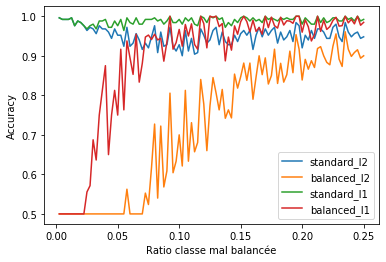

In [11]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score

ratio = list(_/400.0 for _ in range(1, 101))
rows = []
for r in ratio:
    data = generate_data(1000, r, noise=0.0)
    while True:
        X_train, X_test, y_train, y_test = train_test_split(data[["X1", "X2"]], data["cl"])
        if sum(y_test) > 0 and sum(y_train) > 0:
            break
    model = LogisticRegression(penalty='l2', solver='liblinear')
    model.fit(X_train, y_train)
    predt = model.predict(X_test)
    bacc_l2 = balanced_accuracy_score(y_test, predt)
    acc_l2 = accuracy_score(y_test, predt)
    
    model = LogisticRegression(penalty='l1', solver='liblinear')
    model.fit(X_train, y_train)
    predt = model.predict(X_test)
    bacc_l1 = balanced_accuracy_score(y_test, predt)
    acc_l1 = accuracy_score(y_test, predt)

    row = dict(standard_l2=acc_l2, balanced_l2=bacc_l2, ratio=r,
               standard_l1=acc_l1, balanced_l1=bacc_l1)
    rows.append(row)
df = pandas.DataFrame(rows)

fig, ax = plt.subplots(1, 1)
df.plot(x="ratio", y=[_ for _ in df.columns if _ !="ratio"], ax=ax)
ax.set_xlabel("Ratio classe mal balancée")
ax.set_ylabel("Accuracy");

La métrique classique "accuracy" ne permet pas de détecter un problème de classification lorsqu'une classe est mal balancée car chaque exemple est pondéré de la même façon. L'*accuracy* est donc très proche de celle obtenue sur la classe majoritaire.

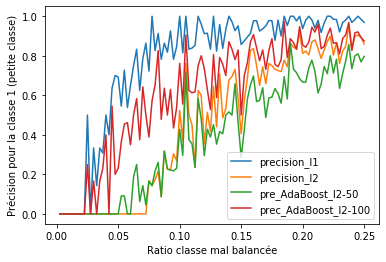

In [12]:
from sklearn.ensemble import AdaBoostClassifier
ratio = list(_/400.0 for _ in range(1, 101))
rows = []
for r in ratio:
    data = generate_data(1000, r, noise=0.0)
    while True:
        X_train, X_test, y_train, y_test = train_test_split(data[["X1", "X2"]], data["cl"])
        if sum(y_test) > 0 and sum(y_train) > 0:
            break
    c = confusion(LogisticRegression(penalty='l1', solver="liblinear"),
                  X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1", "test:y=0"], c.loc["y=1", "test:y=1"]
    row = dict(ratio=r, precision_l1=c1 / (c0 + c1) )
    c = confusion(LogisticRegression(penalty='l2', solver="liblinear"),
                  X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1", "test:y=0"], c.loc["y=1", "test:y=1"]
    row["precision_l2"] = c1 / (c0 + c1)
    c = confusion(AdaBoostClassifier(LogisticRegression(penalty='l2', solver="liblinear"),
                                     algorithm="SAMME.R", n_estimators=50,
                                     learning_rate=3),
                  X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1", "test:y=0"], c.loc["y=1", "test:y=1"]
    row["pre_AdaBoost_l2-50"] = c1 / (c0 + c1)
    c = confusion(AdaBoostClassifier(LogisticRegression(penalty='l2', solver="liblinear"),
                                     algorithm="SAMME.R", n_estimators=100,
                                     learning_rate=3),
                  X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1", "test:y=0"], c.loc["y=1", "test:y=1"]
    row["prec_AdaBoost_l2-100"] = c1 / (c0 + c1)
    rows.append(row)
df = pandas.DataFrame(rows)

fig, ax = plt.subplots(1, 1)
df.plot(x="ratio", y=[_ for _ in df.columns if _ != "ratio"], ax=ax)
ax.set_xlabel("Ratio classe mal balancée")
ax.set_ylabel("Précision pour la classe 1 (petite classe)");

On voit que l'algorithme [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) permet de favoriser les petites classes mais il faut jouer avec le learning rate et le nombre d'estimateurs.

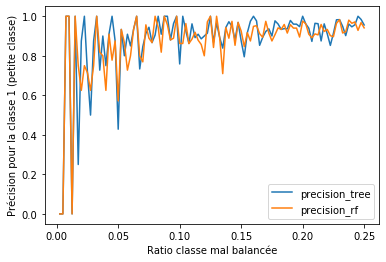

In [13]:
from sklearn.ensemble import AdaBoostClassifier
ratio = list(_/400.0 for _ in range(1, 101))
rows = []
for r in ratio:
    data = generate_data(1000, r, noise=0.0)
    while True:
        X_train, X_test, y_train, y_test = train_test_split(data[["X1", "X2"]], data["cl"])
        if sum(y_test) > 0 and sum(y_train) > 0:
            break
    c = confusion(DecisionTreeClassifier(),
                  X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1", "test:y=0"], c.loc["y=1", "test:y=1"]
    row = dict(ratio=r, precision_tree=c1 / (c0 + c1) )
    c = confusion(RandomForestClassifier(n_estimators=10),
                  X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1", "test:y=0"], c.loc["y=1", "test:y=1"]
    row["precision_rf"] = c1 / (c0 + c1)
    rows.append(row)
    
fig, ax = plt.subplots(1, 1)
df = pandas.DataFrame(rows)
df.plot(x="ratio", y=[_ for _ in df.columns if _ != "ratio"], ax=ax)
ax.set_xlabel("Ratio classe mal balancée")
ax.set_ylabel("Précision pour la classe 1 (petite classe)");

Les méthodes ensemblistes fonctionnent mieux dans ce cas car l'algorithme cherche la meilleure séparation entre deux classes de façon à ce que les deux classes soient de chaque côté de cette frontière. La proportion d'exemples a moins d'importance pour le critère de [Gini](https://fr.wikipedia.org/wiki/Coefficient_de_Gini). Dans l'exemple suivant, on trie selon la variable $X_1$ et on cherche la meilleur séparation

In [14]:
data = generate_data(100, 0.08, 0.1).values
data.sort(axis=0)
data[:5]

array([[0.0133622 , 0.00996042, 0.04423642, 0.        ],
       [0.0215605 , 0.0276332 , 0.21230519, 0.        ],
       [0.02827806, 0.03093092, 0.2737886 , 0.        ],
       [0.03648334, 0.03178925, 0.31218421, 0.        ],
       [0.03649288, 0.03712127, 0.34506943, 0.        ]])

In [15]:
from ensae_teaching_cs.ml.gini import gini

def gini_gain_curve(Y):
    "le code n'est pas le plus efficace du monde mais ça suffira"
    g = gini(Y)
    curve = numpy.empty((len(Y),))
    for i in range(1, len(Y)-1):
        g1 = gini(Y[:i])
        g2 = gini(Y[i:])
        curve[i] = g - (g1 + g2) / 2
    return curve

gini_gain_curve([0, 1, 0, 1, 1, 1, 1])

array([5.20836364e+01, 9.52380952e-03, 4.28571429e-02, 1.26190476e-01,
       4.28571429e-02, 2.61904762e-02, 2.55640000e+02])

In [16]:
from ensae_teaching_cs.ml.gini import gini
gini(data[:, 3])

0.9550000000000001

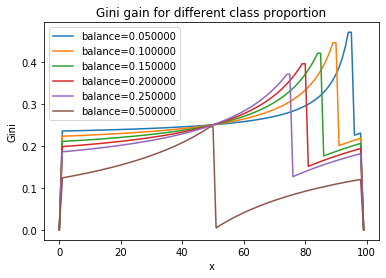

In [17]:
fig, ax = plt.subplots(1, 1)
for skew in [0.05, 0.1, 0.15, 0.2, 0.25, 0.5]:
    data = generate_data(100, skew, 0.1).values
    data.sort(axis=0)
    ax.plot(gini_gain_curve(data[:, 3]), label="balance=%f" % skew)
ax.legend()
ax.set_title("Gini gain for different class proportion")
ax.set_ylabel("Gini")
ax.set_xlabel("x");

Ce n'est pas vraiment pas l'algorithme des arbres de décision mais l'idée est de montrer que les arbres de décision sont moins sensibles aux petites classes quand il s'agit de trouver la meilleure séparation. Et c'est nécessaire car pour les branches les plus basses, tous les sous-échantillons qui terminent dans ces branches sont très mal balancés.

## Exercice 1 : réduire les exemples loin des frontières

Pour rééquilibrer la proportion des classes, on cherche à enlever des points de la base d'apprentissage pour lesquels il n'y a pas d'ambiguïté, c'est-à-dire loin des frontières. Imaginer une solution à l'aides des [k plus proches voisins](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

## Exercice 2 : multiplier les exemples

L'idée est d'utiliser une technique pour multiplier les exemples de la classe sous-représentée sans pour autant avoir des exemples exactement identiques. On utilise l'algorithme [SMOTE](http://jair.org/media/953/live-953-2037-jair.pdf). En résumé, l'algorithme consiste à créer des exemples pour la classe sous-représentée. On choisit un de ces exemples $X$. Pour cet $X$, on calcule ses $k$ plus proches voisins dans la base d'apprentissage, toutes classes comprises. On choisit un voisin aléatoire $V$ parmi les $k$ voisins. On tire un nombre aléaloire $h\in]0,1]$. Le nouvel élément ajouté à la base d'apprentissage est $X + h (V-X)$ et il est associé à la classe sous-représentée. On continue jusqu'à la proportion souhaitée.

* [SMOTE: Synthetic Minority Over-sampling Technique](http://jair.org/media/953/live-953-2037-jair.pdf)
* [Detecting Click Fraud in Online Advertising: A Data Mining Approach](http://www.jmlr.org/papers/volume15/oentaryo14a/oentaryo14a.pdf)
* [On the Statistical Consistency of Algorithms for Binary Classification under Class Imbalance](http://jmlr.org/proceedings/papers/v28/menon13a.pdf)
* [On multi-class classification through the minimization of the confusion matrix norm](http://jmlr.org/proceedings/papers/v29/Koco13.pdf)

## Exercice 3 : essai du module imbalanced

Ce module implémente différentes façons de gérer les classes sous et sur-représentées.

* [algorithmes implémentés](https://github.com/scikit-learn-contrib/imbalanced-learn#about)
* [exemples - imbalanced-learn](http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/index.html)

## Exercice 4 : validation croisée

Lorsqu'une classe est sous représentée, la validation croisée doit être effectuée sous contrainte. Si elle est réalisée de façon complètement aléatoire, il est probable que la classe sous représentée ne soit pas présente. Si la classe 0 possède $k$ exemples parmi $N$, quelle est la distribution du minimum d'observations dans une des clasees ? Il veut comparer une crossvalidation classique avec un échantillon stratigiée ([StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)).